In [4]:
# Necessary imports for this notebook
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Transaction Data Simulator

### Data Generation for Customer and Transaction Simulation

Since we couldn't find a dataset that hasn't anonymized the features for this problem, we'll generate our own synthetic data. Below is the process for generating the required tables:

#### **1. Customer Table**

The **Customer** table will contain the following columns:

- **CUSTOMER_ID**: A unique identifier for each customer.
- **(x_customer_id, y_customer_id)**: A pair of real coordinates \((x, y)\) on a 100x100 grid that represents the geographical location of the customer.
- **(mean_amount, std_amount)**: The mean and standard deviation of the transaction amounts for the customer, where:
  - **mean_amount** is drawn from a uniform distribution between 5 and 100.
  - **std_amount** is set to half of the **mean_amount**.
- **mean_nb_tx_per_day**: The average number of transactions per day for the customer, drawn from a uniform distribution between 0 and 4. This follows a Poisson distribution.

#### **2. Terminal Table**

The **Terminal** table will contain the following columns:

- **TERMINAL_ID**: A unique identifier for each terminal.
- **(x_terminal_id, y_terminal_id)**: A pair of real coordinates \((x, y)\) on a 100x100 grid that represents the geographical location of the terminal.

#### **3. Transaction Table**

The **Transaction** table will have the following fields:

- **Transaction ID**: A unique identifier for each transaction.
- **Date and Time**: The timestamp at which the transaction occurs.
- **Customer ID**: The unique identifier of the customer associated with the transaction.
- **Terminal ID**: The unique identifier of the terminal where the transaction took place.
- **Transaction Amount**: The amount involved in the transaction.
- **Fraud Label**: A binary value indicating whether the transaction is legitimate or fraudulent.

### **Summary of Data Generation Process**

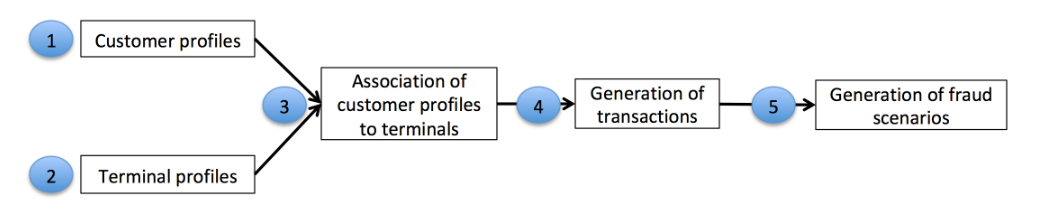

# EDA

## Import Dataset

In [24]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

In [25]:
DIR_INPUT = '../artifacts/simulated-data-raw/'

BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load  files")
transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
1767502 transactions loaded, containing 14303 fraudulent transactions


In [26]:
transactions_df.head()

,TX_TIME_SECONDS,TX_TIME_DAYS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_DATETIME,TRANSACTION_ID,TX_FRAUD,TX_FRAUD_SCENARIO
0,35,0,916,2567,113.90,2018-04-01 00:00:35,0,0,0
1,98,0,3506,6673,11.54,2018-04-01 00:01:38,1,0,0
2,193,0,1534,475,58.48,2018-04-01 00:03:13,2,0,0
3,249,0,2085,7149,68.79,2018-04-01 00:04:09,3,0,0
4,250,0,4464,4162,89.36,2018-04-01 00:04:10,4,0,0


In [27]:
transactions_df['TX_FRAUD_SCENARIO'].unique()

array([0, 2, 3, 1], dtype=int64)

Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide an obvious fraud pattern that should be detected by any baseline fraud detector. This will be useful to validate the implementation of a fraud detection technique.

Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. Detecting this scenario will be possible by adding features that keep track of the number of fraudulent transactions on the terminal. Since the terminal is only compromised for 28 days, additional strategies that involve concept drift will need to be designed to efficiently deal with this scenario.

Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains. Detecting this scenario will require adding features that keep track of the spending habits of the customer. As for scenario 2, since the card is only temporarily compromised, additional strategies that involve concept drift should also be designed.

## Feature Engineering

Here is a summary of all the new features that we'll create :  

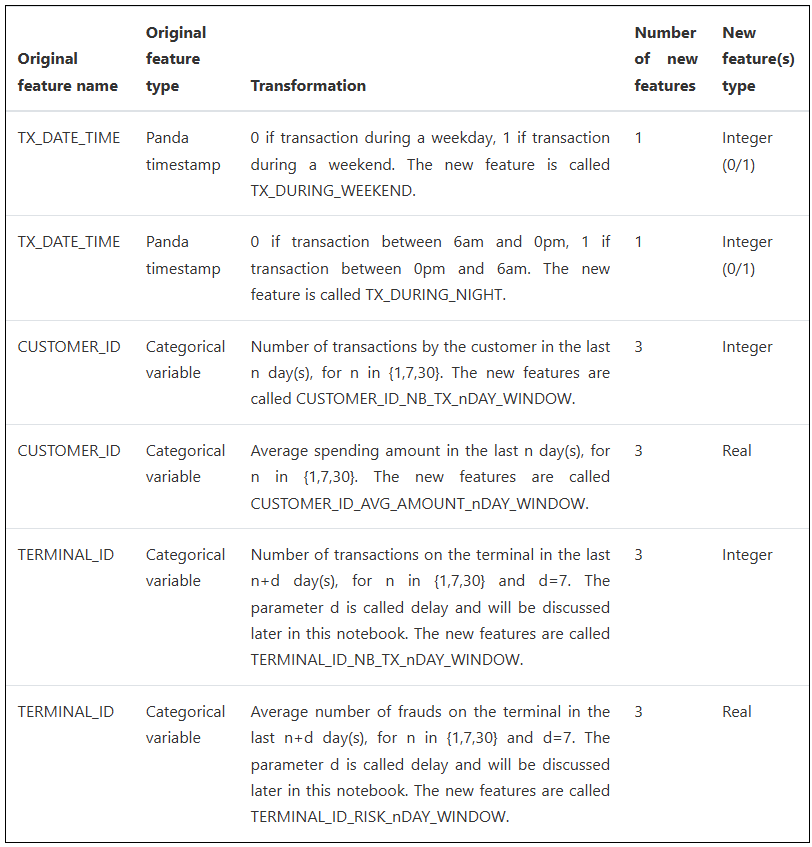

### Feature engineering on dates and times

Here we'll create 2 news features.  
The first one will characterize whether a transaction occurs during a weekday or during the weekend. The second will characterize whether a transaction occurs during the day or the night. These features can be useful since it has been observed in real-world datasets that fraudulent patterns differ between weekdays and weekends, and between the day and night.

In [28]:
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [29]:
transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

In [30]:
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [31]:
transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

In [33]:
transactions_df[transactions_df.TX_TIME_DAYS>=30].head(5)

,TX_TIME_SECONDS,TX_TIME_DAYS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_DATETIME,TRANSACTION_ID,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT
289996,2592016,30,3853,6453,39.60,2018-05-01 00:00:16,289996,0,0,0,1
289997,2592277,30,3394,2796,99.05,2018-05-01 00:04:37,289997,0,0,0,1
289998,2592313,30,3370,6938,83.67,2018-05-01 00:05:13,289998,0,0,0,1
289999,2592342,30,2663,8095,100.58,2018-05-01 00:05:42,289999,0,0,0,1
290000,2592351,30,977,8864,77.89,2018-05-01 00:05:51,290000,0,0,0,1


### Feature engineering on Customer ID

The second type of transformation involves the customer ID and consists in creating features that characterize the customer spending behaviors. We will follow the RFM (Recency, Frequency, Monetary value), and keep track of the average spending amount and number of transactions for each customer and for three window sizes. This will lead to the creation of six new features.

In [34]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

In [35]:
transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

C:\Users\bapti\AppData\Local\Temp\ipykernel_8348\2557592315.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))


In [36]:
transactions_df.head(5)

,TX_TIME_SECONDS,TX_TIME_DAYS,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_DATETIME,TRANSACTION_ID,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,35,0,916,2567,113.90,2018-04-01 00:00:35,0,0,0,1,1,1.0,113.90,1.0,113.90,1.0,113.90
1,98,0,3506,6673,11.54,2018-04-01 00:01:38,1,0,0,1,1,1.0,11.54,1.0,11.54,1.0,11.54
2,193,0,1534,475,58.48,2018-04-01 00:03:13,2,0,0,1,1,1.0,58.48,1.0,58.48,1.0,58.48
3,249,0,2085,7149,68.79,2018-04-01 00:04:09,3,0,0,1,1,1.0,68.79,1.0,68.79,1.0,68.79
4,250,0,4464,4162,89.36,2018-04-01 00:04:10,4,0,0,1,1,1.0,89.36,1.0,89.36,1.0,89.36


### Feature engineering on Terminal ID

The third type of transformation involves the terminal ID and consists in creating new features that characterize the ‘risk’ associated with the terminal. The risk will be defined as the average number of frauds that were observed on the terminal for three window sizes. This will lead to the creation of three new features.

In [37]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [38]:
transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

C:\Users\bapti\AppData\Local\Temp\ipykernel_8348\3343801630.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))


In [ ]:
transactions_df.head(5)

In [ ]:
# To save the new dataset

# DIR_OUTPUT = "./simulated-data-transformed/"

# if not os.path.exists(DIR_OUTPUT):
#     os.makedirs(DIR_OUTPUT)

# start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

# for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
#     transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
#     date = start_date + datetime.timedelta(days=day)
#     filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
#     # Protocol=4 required for Google Colab
#     transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)